# Немного о запрещенном
Небольшой проект, посвященный анализу [федерального списка экстремистских материалов](http://minjust.ru/ru/extremist-materials)

Посмотрим, что чаще всего запрещают и какие слова встречаются в материалах

In [2]:
import sys
sys.path.append('/Users/dmitrys/anaconda2/lib/python2.7/site-packages')
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from docx import Document

from nltk import FreqDist

Хорошая функция для доставания таблицы из .docx документа, спасибо [вот этому посту](http://stackoverflow.com/questions/27861732/parsing-of-table-from-docx-file) на stackoverflow

In [3]:
def readWordTable(document_name='ekstremizm_2_6_3_1_0_0_1_7_1 copy.docx'):
    document = Document(document_name)
    data = []
    
    for table in document.tables:
        # Data will be a list of rows represented as dictionaries
        # containing each row's data.
        
        keys = None
        for i, row in enumerate(table.rows):
            text = (cell.text for cell in row.cells)

            # Establish the mapping based on the first row
            # headers; these will become the keys of our dictionary
            if i == 0:
                keys = tuple(text)
                continue

            # Construct a dictionary for this row, mapping
            # keys to values for this row
            row_data = tuple(text)
            data.append(row_data)
    return data

In [4]:
data = readWordTable()

In [5]:
len(data)

4041

In [6]:
print(data[1][1])

Письма Рады земли Кубанской духовно-родовой державы Русь, авторы - Н.М. Лозинский, В.М. Герасев, решение вынесено Первомайским районным судом г. Краснодара от 20.03.2006;


In [11]:
text = pd.DataFrame(data)

In [15]:
text.head()

,0,1,2,3,4,5,6,7
0,2.,"Книга ""Книга единобожия"", автор - Мухаммад ибн...",None,None,None,None,None,None
1,3.,Письма Рады земли Кубанской духовно-родовой де...,None,None,None,None,None,None
2,4.,"Печатные материалы в газете ""Для русских людей...",None,None,None,None,None,None
3,5.,"Кинофильм ""Вечный жид"", решение вынесено Тихви...",None,None,None,None,None,None
4,6.,"Брошюра ""Мать-земля: чудо-чудное, диво-дивное....",None,None,None,None,None,None


Перегоним все столбцы в один

In [12]:
final = pd.DataFrame()
for i in text.columns:
    final = pd.concat([final, text[i][~text[i].isnull()]], ignore_index=True)

In [14]:
final.tail()

,0
14391,Информационный материал - текст музыкально-тек...
14392,"Информационные материалы, размещенные в статье..."
14393,2942.
14394,"Текстовый документ, распространенный Стригунов..."
14395,Информационный материал – текст музыкальной ко...


In [16]:
text = final.copy()

## Лемматизация

In [17]:
text.columns = ["banned"]

from pymystem3 import Mystem

m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

text.banned = text.banned.apply(lemmatize)

In [19]:
text.tail()

,banned
14391,информационный материал - текст музыкально-тек...
14392,"информационный материал, размещать в статья «в..."
14393,2942.
14394,"текстовый документ, распространять стригунов и..."
14395,информационный материал – текст музыкальный ко...


## Выкидываем стоп-слова

В стоп-слова из nltk добавляем специфические слова для данного корпуса, которые встречаются практически в каждом документе

In [20]:
from nltk.corpus import stopwords
mystopwords = stopwords.words('russian') + "сеть размещать суд городской районный москва интернет вконтакте социальный электронный адрес год решение wmv jpg республика длительность \
минута заканчиваться начинаться".split()

In [22]:
def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token.decode('utf-8') for token in text.split() if not token in mystopwords])
    except:
        return ""

text.banned = text.banned.apply(remove_stopwords)   

/Users/dmitrys/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  app.launch_new_instance()


In [24]:
text.tail()

,banned
14391,информационный материал - текст музыкально-тек...
14392,"информационный материал, статья «взлет падение..."
14393,2942.
14394,"текстовый документ, распространять стригунов и..."
14395,информационный материал – текст музыкальный ко...


## Очистка от пунктуации

In [28]:
import string
def cleanString(myString):
    return myString.encode('utf-8').translate(None, string.punctuation).decode('utf-8')

text.banned = text.banned.apply(cleanString)

In [29]:
text.tail()

,banned
14391,информационный материал текст музыкальнотекст...
14392,информационный материал статья «взлет падение ...
14393,2942
14394,текстовый документ распространять стригунов ис...
14395,информационный материал – текст музыкальный ко...


### Посмотрим на самые часто встречающиеся и убедимся, что это тоже мусор

In [31]:
lemmata = []
for i in range(len(text)):
    lemmata += text.banned.iloc[i].split()
fd = FreqDist(lemmata)

In [32]:
for i in fd.most_common(10):
    print(i[0])

решение
г
–
страница
материал
сайт
информационный
город
область
адрес


In [53]:
cloud = ''
for i in text.banned:
    cloud += (' '+i)

### Выкидываем из собранного текстового массива самые часто встречающиеся слова, чтобы откинуть номенклатурные формулировки

In [65]:
common = " ".join([i[0] for i in fd.most_common(120)])
common += u" мы заголовок"

Посмотрим на то, что будем выкидывать

In [66]:
print(common)

решение г – страница материал сайт информационный город область адрес текст название слово изображение видеоролик статья «интернет» который надпись «вконтакте» русский № продолжительность книга ленинский определение видеофайл группа секунда интернетсайт пользователь автор советский видеоматериал видеозапись «в центральный издание «русский мина располагать сечь интернетстраница край человек санктпетербург опубликовывать октябрьский 1 информационныйтелекоммуникационный брошюра аудиозапись издательство белый фотография контакт» лицо 2 газета кировский печатный песня автономный 3 файл округ часть россия журнал листовка рисунок аудиофайл дело черный интернетресурс россия» международный имя мужчина содержать с фон 2011 чита «обращение иметь казань это гражданский судебный коллегия текстовый башкортостан рука весь ямалоненецкий «россия новосибирск информация вид московский цвет содержаться телекоммуникационный 4 русский» убивать ресурс графический первомайский являться музыкальный компьютерны

In [67]:
cloud = " ".join([word for word in cloud.split() if word not in common])

## WordCloud

In [68]:
from PIL import Image

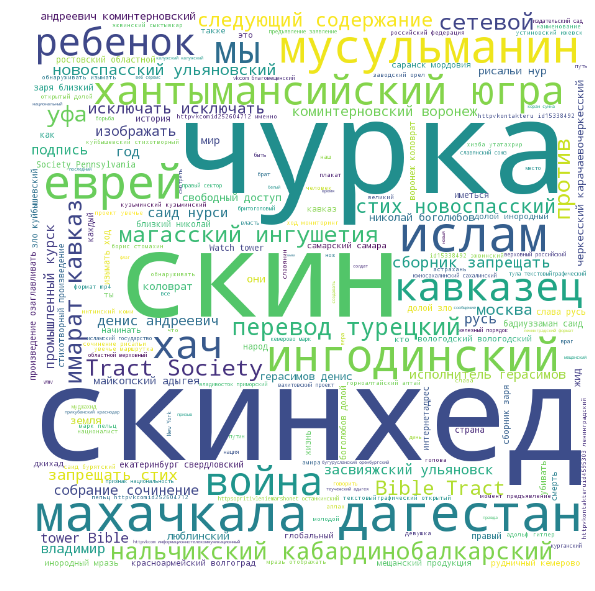

In [69]:
wordcloud = WordCloud(background_color="white", max_words=200, width=900, height=900)
wordcloud = wordcloud.generate(cloud)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear',)
plt.axis("off");

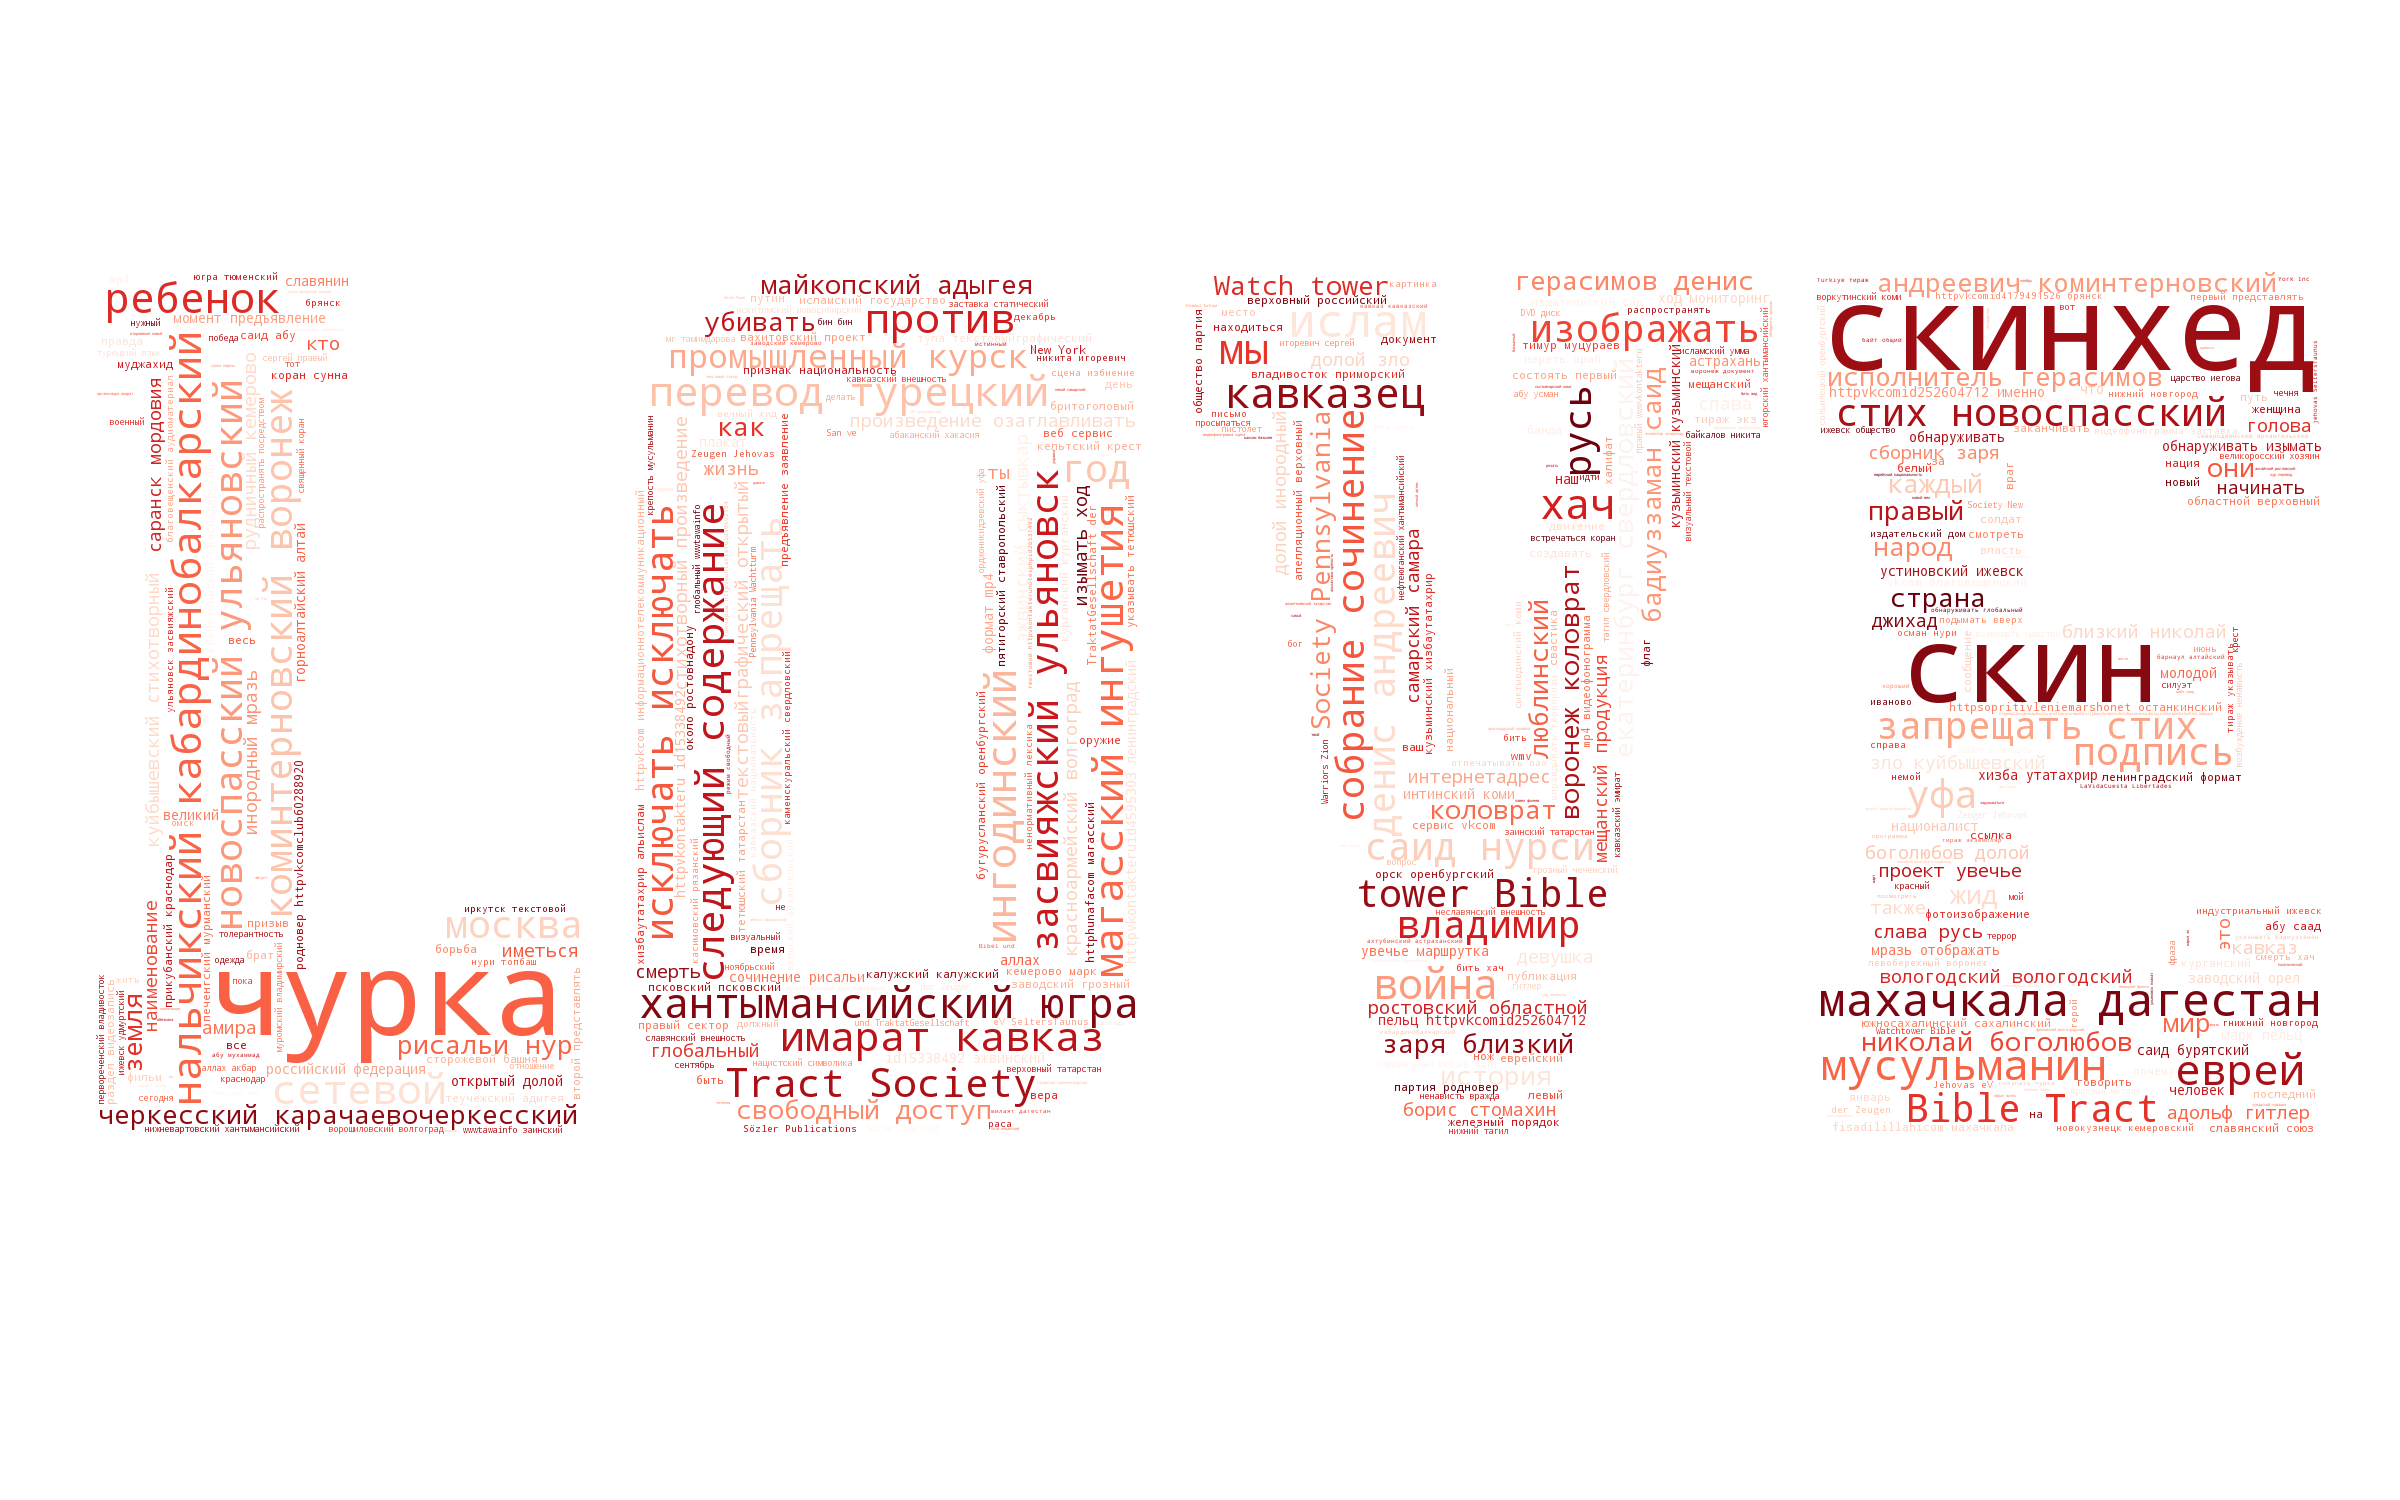

In [70]:
pic = np.array(Image.open("LOVE.jpg"))
wordcloud = WordCloud(background_color="white", max_words=500, mask=pic, colormap='Reds')
wordcloud = wordcloud.generate(cloud)
wordcloud.to_image()